In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.anova import anova_lm

In [2]:
# df here stands for exactly the same as it does in file "01";
df = pd.read_csv("Raw Data.csv") # The name of participants have been removed right after the experiment.
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.isnull().sum()

age              0
gender           0
SPS              0
FA1              0
FA2              0
FA3              0
FA4              0
RAT              0
BT               0
CSE              0
Group            0
Stage1           0
Stage2           0
Num              0
Stage2_Stage1    0
dtype: int64

In [3]:
df.describe()

,age,gender,SPS,FA1,FA2,FA3,FA4,RAT,BT,CSE,Group,Stage1,Stage2,Num,Stage2_Stage1
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,19.901478,1.773399,101.049261,5.201970,8.285714,12.142857,9.192118,6.078818,4.901478,27.162562,0.507389,13.487685,21.334975,108.931034,7.847291
std,1.210575,0.419667,11.640980,3.329079,4.915841,6.703353,4.110785,2.247924,2.036826,6.612183,0.501181,7.227121,9.768413,62.101683,8.050050
min,18.000000,1.000000,65.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,7.000000,0.000000,3.000000,5.000000,1.000000,-17.000000
25%,19.000000,2.000000,94.000000,3.000000,5.000000,7.000000,6.000000,5.000000,3.000000,23.000000,0.000000,8.000000,14.000000,55.500000,2.000000
50%,20.000000,2.000000,102.000000,4.000000,7.000000,11.000000,9.000000,6.000000,5.000000,28.000000,1.000000,12.000000,19.000000,109.000000,7.000000
75%,21.000000,2.000000,109.000000,7.000000,11.000000,15.500000,11.500000,8.000000,6.000000,32.000000,1.000000,17.000000,28.000000,161.500000,13.000000
max,22.000000,2.000000,128.000000,18.000000,23.000000,34.000000,22.000000,11.000000,10.000000,42.000000,1.000000,37.000000,49.000000,216.000000,35.000000


In [4]:
group0 = df[df["Group"]== 0]
group1 = df[df["Group"]== 1]

for var in ["FA1", "FA2", "SPS"]:
    t_stat, p_val = stats.ttest_ind(group0[var], group1[var], equal_var=False)  # Welch's t-test
    print(f"{var}: t={t_stat:.3f}, p={p_val:.3f}")

FA1: t=0.832, p=0.407
FA2: t=2.051, p=0.042
SPS: t=0.254, p=0.800


As shown above, the intergroup differences of FA1 and SPS show no significance (p > .05), while the intergroup difference of FA2 shows some significance.
However, the t value of FA2 is relatively high, which points out a potential reason.

The grouping of this experiment is fully randoned, so there should not be a systematic reason causing this imbalance grouping.

In [5]:
for var in ["Stage1", "SPS"]:
    t_stat, p_val = stats.ttest_ind(group0[var], group1[var], equal_var=False)  # Welch's t-test
    print(f"{var}: t={t_stat:.3f}, p={p_val:.3f}")

Stage1: t=1.777, p=0.077
SPS: t=0.254, p=0.800


There is no significance between Group0 and Group1, when considering Stage1 scores and SPS scores. When combining FA1 and FA2 together as Stage1, the p value is relatively satisfied, and the t value is acceptable, too. In the following analysis, the analysis would mainly use Stage1 score stands for the sum of FA1 and FA2. Similarly, Stage2 stands for the sum of FA3 and FA4 in the following analysis.

In [6]:
# The labels of Low, Medium, and High refer to individuals with low sensitivity, medium sensitivity, and high sensitivity, respectively.
def categorize_sps(score):
    if score <= 94:
        return "Low"
    elif 95 <= score <= 107:
        return "Medium"
    else:
        return "High"

df["SPS_Group"] = df["SPS"].apply(categorize_sps)
group_order = ["Low", "Medium", "High"]
print(df["SPS_Group"].value_counts().reindex(group_order))

SPS_Group
Low       56
Medium    83
High      64
Name: count, dtype: int64


The ratio of people between the three groups is approximately 3:4:3.

In [7]:
group_order = ["Low", "Medium", "High"]
vars_to_describe = ["Stage1", "Stage2", "RAT", "BT", "CSE"]

desc_stats = []

for var in vars_to_describe:
    for group in group_order:
        group_data = df[df["SPS_Group"]==group][var].dropna()
        mean = group_data.mean()
        std = group_data.std()
        n = group_data.count()
        desc_stats.append({
            "Variable": var,
            "SPS_Group": group,
            "N": n,
            "Mean": mean,
            "Std": std
        })

desc_df = pd.DataFrame(desc_stats)
group_order = ["Low", "Medium", "High"]
desc_df["SPS_Group"] = pd.Categorical(desc_df["SPS_Group"], categories=group_order, ordered=True)

var_order = ["Stage1", "Stage2", "RAT", "BT", "CSE"]
desc_df["Variable"] = pd.Categorical(desc_df["Variable"], categories=var_order, ordered=True)

desc_df_sorted = desc_df.sort_values(by=["SPS_Group", "Variable"])

print(desc_df_sorted)

   Variable SPS_Group   N       Mean        Std
0    Stage1       Low  56  11.482143   7.473568
3    Stage2       Low  56  19.892857  10.080906
6       RAT       Low  56   5.785714   2.163451
9        BT       Low  56   4.946429   1.843116
12      CSE       Low  56  27.571429   5.830506
1    Stage1    Medium  83  14.987952   7.469440
4    Stage2    Medium  83  21.915663  10.313624
7       RAT    Medium  83   6.349398   2.276249
10       BT    Medium  83   5.228916   2.259534
13      CSE    Medium  83  26.734940   6.307341
2    Stage1      High  64  13.296875   6.285988
5    Stage2      High  64  21.843750   8.730932
8       RAT      High  64   5.984375   2.278207
11       BT      High  64   4.437500   1.824655
14      CSE      High  64  27.359375   7.635272


This is a scoring table based on SPS grouping.

In [8]:
stage1_vars = ["Stage1", "SPS"] 
for var in stage1_vars:
    print(f"=== {var} ===")
    
    groups_data = [df[df["SPS_Group"]==g][var].dropna() for g in group_order]
    
    # 3.1 Shapiro-Wilk Test
    for g_name, g_data in zip(group_order, groups_data):
        if len(g_data) >= 3:  # Shapiro sample must >= 3
            stat, p = stats.shapiro(g_data)
            print(f"{g_name} group Shapiro-Wilk: W={stat:.3f}, p={p:.3f}")
        else:
            print(f"{g_name} group Shapiro-Wilk: The sample is too small to be tested")
    
    # 3.2 Levene Test
    if all(len(g) > 1 for g in groups_data):
        lev_stat, lev_p = stats.levene(*groups_data)
        print(f"Levene test for equal variance: W={lev_stat:.3f}, p={lev_p:.3f}")
    else:
        print("Homogeneity test of variance: too few samples to test")
    
    # 3.3 One-way ANOVA
    model = ols(f"{var} ~ C(SPS_Group)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA Result:")
    print(anova_table)
    
    # 3.4 Tukey HSD P
    tukey = pairwise_tukeyhsd(endog=df[var], groups=df["SPS_Group"], alpha=0.05)
    print("\nTukey HSD Post Hoc Test:")
    print(tukey.summary())
    
    print("\n----------------------------\n")

=== Stage1 ===
Low group Shapiro-Wilk: W=0.832, p=0.000
Medium group Shapiro-Wilk: W=0.933, p=0.000
High group Shapiro-Wilk: W=0.910, p=0.000
Levene test for equal variance: W=0.969, p=0.381

ANOVA Result:
                    sum_sq     df         F    PR(>F)
C(SPS_Group)    414.389742    2.0  4.088164  0.018191
Residual      10136.329470  200.0       NaN       NaN

Tukey HSD Post Hoc Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  High    Low  -1.8147 0.3464 -4.8907 1.2612  False
  High Medium   1.6911 0.3285 -1.1054 4.4875  False
   Low Medium   3.5058 0.0134  0.5988 6.4128   True
---------------------------------------------------

----------------------------

=== SPS ===
Low group Shapiro-Wilk: W=0.896, p=0.000
Medium group Shapiro-Wilk: W=0.930, p=0.000
High group Shapiro-Wilk: W=0.896, p=0.000
Levene test for equal variance: W=5.900, p=0.003

ANOVA Result:
        

**Stage1 Task Score**<br>
The normality of the scores of each SPS group in Stage1 is not satisfied, but the homogeneity of variance holds. The ANOVA test showed a significant overall difference in scores among the three groups (F=4.088, p=0.018). Tukey's post hoc test found a significant difference between Low and Medium, while the rest of the comparisons were not significant. Overall, the differences in Stage1 scores among the three groups are accepted, and the baseline levels can be considered close. More importantly, we would consider more on the baseline based changes, rather than baseline levels.

**SPS Total Score**<br>
The normality of scores in each group is not satisfied and the variance is uneven, but both ANOVA and Tukey HSD tests show significant differences among the groups. The SPS grouping is effective, with significant differences in sensitivity levels among the Low/Medium/High groups, providing a reliable grouping basis for subsequent analysis.

In [9]:
dv_columns = ["Stage1", "RAT", "BT", "Stage2", "CSE"] 

group_stats = df.groupby(['Group', 'SPS_Group'], observed=True)[dv_columns].agg(['mean'])

print(group_stats)

                    Stage1       RAT        BT     Stage2        CSE
                      mean      mean      mean       mean       mean
Group SPS_Group                                                     
0.0   High       14.482759  6.000000  4.206897  22.068966  27.034483
      Low        13.478261  6.173913  5.260870  19.913043  26.391304
      Medium     14.791667  6.291667  5.375000  20.041667  27.750000
1.0   High       12.314286  5.971429  4.628571  21.657143  27.628571
      Low        10.090909  5.515152  4.727273  19.878788  28.393939
      Medium     15.257143  6.428571  5.028571  24.485714  25.342857


Observating the table, there exists a big difference between the Stage2 score of Group0 Medium participants (20.041667) and Group1 Medium participants (24.485714);

In [10]:
# Multivariate MANOVA
maov = MANOVA.from_formula('RAT + BT + Stage2 ~ C(Group) * C(SPS_Group)', data=df)

print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.3287 3.0000 195.0000 132.7205 0.0000
         Pillai's trace 0.6713 3.0000 195.0000 132.7205 0.0000
 Hotelling-Lawley trace 2.0419 3.0000 195.0000 132.7205 0.0000
    Roy's greatest root 2.0419 3.0000 195.0000 132.7205 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
         C(Group)        Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9958 3.0000 195.0000  0.2731 0.8447
          Pillai's trace 0.0042 3.0000 195.0000  0.2731 0.8447
  Hotelling

In terms of the overall performance of the three dependent variables (RAT, BT, Stage2), there were no differences between the two groups (Group).<br>
The SPS grouping also showed no significant overall differences, and the interaction between the two was not significant. However, at the univariate level, SPS_Group may have a significant effect on BT (p = .0326), which requires confirmation through univariate ANOVA or post-hoc tests.

In [11]:
# Two-way ANOVA for each dependent variable (RAT, BT, Stage2)
DVs = ["RAT", "BT", "Stage2"]
results = {}

for dv in DVs:
    model = ols(f'{dv} ~ C(Group) * C(SPS_Group)', data=df).fit()
    anova_res = anova_lm(model, typ=3) 
    results[dv] = anova_res
    print(f"\n==== {dv} ====")
    print(anova_res)


==== RAT ====
                            sum_sq     df           F        PR(>F)
Intercept              1044.000000    1.0  205.051554  2.406934e-32
C(Group)                  0.012946    1.0    0.002543  9.598338e-01
C(SPS_Group)              1.538986    2.0    0.151136  8.598306e-01
C(Group):C(SPS_Group)     5.394025    2.0    0.529719  5.896067e-01
Residual               1003.006296  197.0         NaN           NaN

==== BT ====
                           sum_sq     df           F        PR(>F)
Intercept              513.241379    1.0  125.424357  7.596198e-23
C(Group)                 2.819951    1.0    0.689131  4.074650e-01
C(SPS_Group)            26.546597    2.0    3.243688  4.111330e-02
C(Group):C(SPS_Group)    7.958141    2.0    0.972393  3.799845e-01
Residual               806.131715  197.0         NaN           NaN

==== Stage2 ====
                             sum_sq     df           F        PR(>F)
Intercept              14124.137931    1.0  148.700971  7.540816e-26
C(Gro

Overall, stress conditions (Group) had no significant main effects on RAT, BT, and Stage2; There is a significant difference in sensitivity (SPS-Group) on BT, but it has no significant effect on RAT and Stage2; The interaction term between the two factors is not significant.

Substantive meaning: There are statistically significant differences in the performance of different sensitivity groups on the "Enlightenment (BT)" task (although the effect size is relatively small), while stress manipulation itself does not have an overall impact on these three abilities, nor does it have an interactive effect with sensitivity.

In [12]:
# Do a T-test for the Medium SPS participants;
medium_df = df[df["SPS_Group"] == "Medium"]

# Independent sample T-test
group0 = medium_df[medium_df["Group"] == 0]["Stage2"]
group1 = medium_df[medium_df["Group"] == 1]["Stage2"]

t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False) 
print("Independent sample T-test result：")
print(f"t = {t_stat:.3f}, p = {p_val:.3f}")

Independent sample T-test result：
t = -1.922, p = 0.059


In [13]:
# Independent T-test for multigroups.
def simple_effects(df, dvs, group_col="Group", sps_col="SPS_Group"):
    """
    Conduct simple effects analysis for each DV and each SPS level (Group0 vs Group1),
    and return a tidy table.
    
    Parameters:
        df: pandas.DataFrame, the dataset
        dvs: list, dependent variable column names, e.g., ["Stage2", "RAT", "BT"]
        group_col: str, the column name for the experimental group
        sps_col: str, the column name for SPS grouping
    Returns:
        result_df: pandas.DataFrame, includes means, t-values, and p-values for each DV and SPS level
    """
    results = []

    sps_levels = df[sps_col].unique()
    for dv in dvs:
        for sps in sps_levels:
            subset = df[df[sps_col] == sps]
            group0 = subset[subset[group_col] == 0][dv]
            group1 = subset[subset[group_col] == 1][dv]

            # Welch t-test
            t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)

            results.append({
                "DV": dv,
                "SPS_Level": sps,
                f"{group_col}0_mean": group0.mean(),
                f"{group_col}1_mean": group1.mean(),
                "t": t_stat,
                "p": p_val
            })
    
    result_df = pd.DataFrame(results)
    # Sort by DV first, then by SPS level order: Low -> Medium -> High
    sps_order = ["Low", "Medium", "High"]
    result_df["SPS_Level"] = pd.Categorical(result_df["SPS_Level"], categories=sps_order, ordered=True)
    result_df = result_df.sort_values(by=["DV", "SPS_Level"]).reset_index(drop=True)
    
    return result_df

DVs = ["RAT", "BT", "Stage2"]
simple_results = simple_effects(df, DVs)

print(simple_results)

       DV SPS_Level  Group0_mean  Group1_mean         t         p
0      BT       Low     5.260870     4.727273  1.003343  0.322252
1      BT    Medium     5.375000     5.028571  0.663957  0.509135
2      BT      High     4.206897     4.628571 -0.935588  0.353115
3     RAT       Low     6.173913     5.515152  1.105901  0.274682
4     RAT    Medium     6.291667     6.428571 -0.275382  0.783745
5     RAT      High     6.000000     5.971429  0.050130  0.960181
6  Stage2       Low    19.913043    19.878788  0.012257  0.990274
7  Stage2    Medium    20.041667    24.485714 -1.921761  0.058964
8  Stage2      High    22.068966    21.657143  0.187056  0.852242


The result shows no significance between groups (only Medium SPS participants show a marginal significance).

In [14]:
def cohen_d(x1, x2):
    """Compute Cohen's d for two independent groups (pooled SD)."""
    x1 = np.asarray(x1.dropna())
    x2 = np.asarray(x2.dropna())
    n1, n2 = len(x1), len(x2)
    if n1 < 2 or n2 < 2:
        return np.nan
    s1 = np.var(x1, ddof=1)
    s2 = np.var(x2, ddof=1)
    pooled = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    if pooled == 0:
        return np.nan
    return (np.mean(x1) - np.mean(x2)) / pooled

def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

def simple_effects_table(df, dv_list, group_col="Group", sps_col="SPS_Group",
                         sps_order=None):
    """
    For each DV in dv_list, fit DV ~ C(Group) * C(SPS_Group),
    then test the simple effect of Group (Group1 - Group0) at each SPS level
    using model.t_test (so test uses overall model residual variance).
    Returns DataFrame with means, diff, Cohen's d, t, p, Sig.
    """
    results = []

    # Ensure SPS grouping is categorical and has a stable order
    if sps_order is None:
        # if expected labels exist, prefer that order
        expected = ["Low", "Medium", "High"]
        if set(expected).issubset(set(df[sps_col].unique())):
            sps_order = expected
        else:
            sps_order = sorted(df[sps_col].unique().tolist())
    df[sps_col] = pd.Categorical(df[sps_col], categories=sps_order, ordered=True)
    sps_levels = df[sps_col].cat.categories

    for dv in dv_list:
        # Fit full model (with interaction)
        formula = f"{dv} ~ C({group_col}) * C({sps_col})"
        model = ols(formula, data=df).fit()

        params = list(model.params.index)  # parameter names

        # find the group main-effect param name (e.g. "C(Group)[T.1]"), if any
        gm_param = None
        for p in params:
            if p.startswith(f"C({group_col})[T.") and ":" not in p:
                gm_param = p
                break

        for lvl in sps_levels:
            # means and cohen's d based on subgroup data
            sub = df[df[sps_col] == lvl]
            g0 = sub[sub[group_col] == 0][dv]
            g1 = sub[sub[group_col] == 1][dv]
            mean0 = float(g0.mean()) if len(g0) > 0 else np.nan
            mean1 = float(g1.mean()) if len(g1) > 0 else np.nan
            diff = mean1 - mean0 if (not np.isnan(mean1) and not np.isnan(mean0)) else np.nan
            d = cohen_d(g1, g0)

            # Build contrast vector aligned with model.params
            contrast = np.zeros(len(params), dtype=float)

            # If group main param exists, include it
            if gm_param is not None:
                idx_gm = params.index(gm_param)
                # For reference level of SPS (first category), group effect is just gm_param
                # For other levels we need gm_param + interaction term
                contrast[idx_gm] = 1.0

                # Look for interaction parameter names
                # Possible names: "C(Group)[T.1]:C(SPS_Group)[T.Medium]" or reversed order
                inter_name_1 = f"{gm_param}:C({sps_col})[T.{lvl}]"
                inter_name_2 = f"C({sps_col})[T.{lvl}]:{gm_param}"

                if inter_name_1 in params:
                    contrast[params.index(inter_name_1)] = 1.0
                elif inter_name_2 in params:
                    contrast[params.index(inter_name_2)] = 1.0
                # Note: if SPS level is the reference (first), no interaction term exists for it.

            else:
                # Fallback: if no gm_param found, try to locate any param that encodes Group main effect
                for p in params:
                    if f"C({group_col})" in p and ":" not in p:
                        idx = params.index(p)
                        contrast[idx] = 1.0
                        break
                # and similarly add interaction if present
                # (handled above if gm_param was found)

            # If both groups have at least one obs, run t_test; else set NaNs
            if len(g0) > 0 and len(g1) > 0:
                ttest = model.t_test(contrast)
                # extract scalars safely
                t_val = float(ttest.tvalue.flat[0])
                p_val = float(ttest.pvalue.flat[0])
            else:
                t_val = np.nan
                p_val = np.nan

            results.append({
                "DV": dv,
                "SPS_Level": lvl,
                "Mean_Group0": round(mean0, 3) if not np.isnan(mean0) else np.nan,
                "Mean_Group1": round(mean1, 3) if not np.isnan(mean1) else np.nan,
                "Diff (G1-G0)": round(diff, 3) if not np.isnan(diff) else np.nan,
                "Cohen_d": round(d, 3) if not np.isnan(d) else np.nan,
                "t": round(t_val, 3) if not np.isnan(t_val) else np.nan,
                "p": round(p_val, 4) if not np.isnan(p_val) else np.nan,
                "Sig": significance_marker(p_val) if (not np.isnan(p_val)) else ""
            })

    res_df = pd.DataFrame(results)
    # sort for neatness: DV then SPS order
    res_df["SPS_Level"] = pd.Categorical(res_df["SPS_Level"], categories=sps_order, ordered=True)
    res_df = res_df.sort_values(["DV", "SPS_Level"]).reset_index(drop=True)
    return res_df

DVs = ["RAT", "BT", "Stage2"]
table = simple_effects_table(df, DVs)
print(table)

       DV SPS_Level  Mean_Group0  Mean_Group1  Diff (G1-G0)  Cohen_d      t  \
0      BT       Low        5.261        4.727        -0.534   -0.290 -0.971   
1      BT    Medium        5.375        5.029        -0.346   -0.153 -0.770   
2      BT      High        4.207        4.629         0.422    0.231  0.830   
3     RAT       Low        6.174        5.515        -0.659   -0.305 -1.075   
4     RAT    Medium        6.292        6.429         0.137    0.060  0.273   
5     RAT      High        6.000        5.971        -0.029   -0.012 -0.050   
6  Stage2       Low       19.913       19.879        -0.034   -0.003 -0.013   
7  Stage2    Medium       20.042       24.486         4.444    0.438  2.051   
8  Stage2      High       22.069       21.657        -0.412   -0.047 -0.168   

        p Sig  
0  0.3327      
1  0.4419      
2  0.4075      
3  0.2838      
4  0.7852      
5  0.9598      
6  0.9897      
7  0.0415   *  
8  0.8665      


A Simple Effects Analysis revealed that the effect of Group on Stage2 performance was significant only at the Medium SPS level, t(df=?, ≈2.05), p = .041, d = 0.44, with Group1 scoring higher than Group0.<br>
No significant group differences were observed for Stage2 at Low or High SPS, or for BT and RAT at any SPS level (all ps > .28).

**Periodic conclusion**

1. <span style="color:green; font-weight:bold;">BT scores may differ across SPS groups, indicating a potential effect of SPS on BT.</span>

2. <span style="color:green; font-weight:bold;">Among Medium SPS participants, Stage2 scores are marginaly significantly higher in Group1 than in Group0.</span>

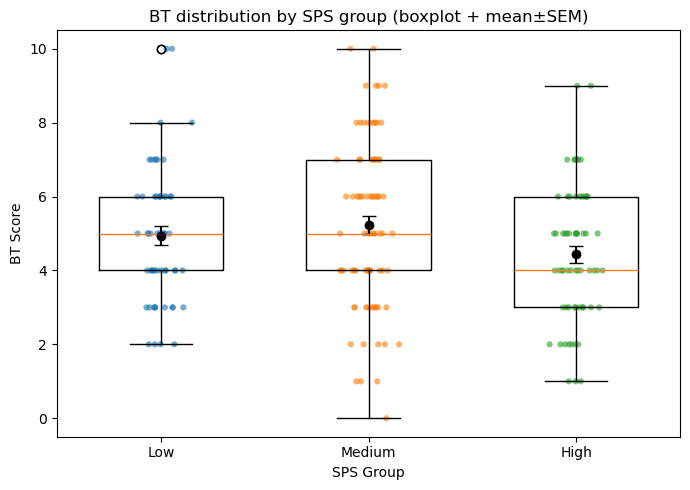

In [15]:
sps_order = ["Low", "Medium", "High"]
if "SPS_Group" in df.columns:
    df["SPS_Group"] = pd.Categorical(df["SPS_Group"], categories=sps_order, ordered=True)
else:
    raise KeyError("DataFrame must contain 'SPS_Group' column")

# Map Group labels for plotting
if df["Group"].dtype != object:
    df["Group_label"] = df["Group"].map({0: "Group0", 1: "Group1"})
else:
    df["Group_label"] = df["Group"].astype(str)

# ---------- Figure A: BT by SPS_Group (box + points + mean±SE) ----------
plt.figure(figsize=(7,5))
ax = plt.gca()

# boxplot (grouped by category order)
box_data = [df[df["SPS_Group"] == lvl]["BT"].dropna().values for lvl in sps_order]
bp = ax.boxplot(box_data, positions=np.arange(len(sps_order))+1, widths=0.6, patch_artist=False)

# overlay individual points (jitter)
for i, lvl in enumerate(sps_order, start=1):
    y = df[df["SPS_Group"] == lvl]["BT"].dropna().values
    x = np.random.normal(i, 0.06, size=len(y))
    ax.scatter(x, y, alpha=0.6, edgecolors='none', s=20)

# plot mean ± SEM
for i, lvl in enumerate(sps_order, start=1):
    grp = df[df["SPS_Group"] == lvl]["BT"].dropna()
    if len(grp) > 0:
        mean = grp.mean()
        sem = grp.std(ddof=1) / np.sqrt(len(grp))
        ax.errorbar(i, mean, yerr=sem, fmt='o', color='black', capsize=5)

ax.set_xticks(np.arange(1, len(sps_order)+1))
ax.set_xticklabels(sps_order)
ax.set_xlabel("SPS Group")
ax.set_ylabel("BT Score")
ax.set_title("BT distribution by SPS group (boxplot + mean±SEM)")
plt.tight_layout()
plt.show()

The above figure shows the score distribution of BT scores in different SPS groups. Obviously, the distribution varies across different SPS groups.

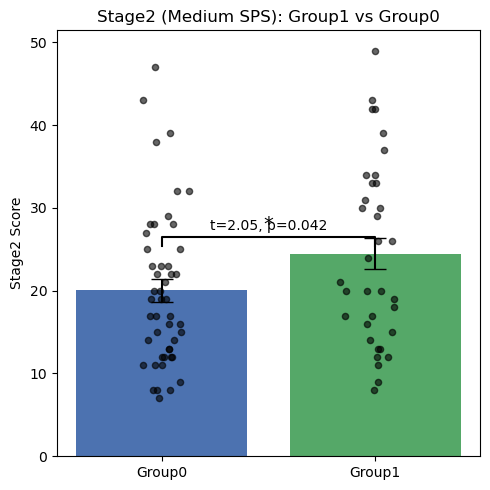

Stage2 (Medium SPS) summary based on model contrast:
  Group0: n=48, mean=20.042, sem=1.356
  Group1: n=35, mean=24.486, sem=1.873
  OLS contrast t = 2.051, p = 0.0415, significance = *


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import patsy
from statsmodels.formula.api import ols

# ---- Step 1: Fit the OLS model with interaction ----
# DV = Stage2, predictors = SPS_Group * Group
model = ols("Stage2 ~ C(SPS_Group) * C(Group)", data=df).fit()

# ---- Step 2: Build contrast for the simple effect ----
# Example: Medium SPS, compare Group1 vs Group0

# Design matrices for contrast construction
y, X = patsy.dmatrices("Stage2 ~ C(SPS_Group) * C(Group)", 
                       data=df, return_type="dataframe")

# Select rows corresponding to Medium SPS by group
idx_g1 = (df["SPS_Group"] == "Medium") & (df["Group"] == 1)
idx_g0 = (df["SPS_Group"] == "Medium") & (df["Group"] == 0)

# Compute average design rows for each condition
row_g1 = X[idx_g1].mean()
row_g0 = X[idx_g0].mean()

# Construct contrast vector
contrast = (row_g1 - row_g0).values

# Model-based t-test
t_res = model.t_test(contrast)
t_stat = t_res.tvalue.item()  # extract scalar safely
p_val = t_res.pvalue.item()   # extract scalar safely

# ---- Step 3: Compute descriptive statistics from raw data ----
medium_df = df[df["SPS_Group"] == "Medium"]
g0 = medium_df[medium_df["Group"] == 0]["Stage2"].dropna()
g1 = medium_df[medium_df["Group"] == 1]["Stage2"].dropna()

mean0, mean1 = g0.mean(), g1.mean()
sem0 = g0.std(ddof=1) / np.sqrt(len(g0)) if len(g0) > 0 else np.nan
sem1 = g1.std(ddof=1) / np.sqrt(len(g1)) if len(g1) > 0 else np.nan

# ---- Step 4: Plot results ----
plt.figure(figsize=(5,5))
x = np.arange(2)
means = [mean0, mean1]
sems = [sem0, sem1]

# Plot bars with error bars
plt.bar(x, means, yerr=sems, capsize=8, color=["#4C72B0", "#55A868"])

# Overlay raw data points with slight jitter
for i, grp in enumerate([g0, g1]):
    xs = np.random.normal(i, 0.06, size=len(grp))
    plt.scatter(xs, grp, alpha=0.6, s=20, color="black")

plt.xticks(x, ["Group0", "Group1"])
plt.ylabel("Stage2 Score")
plt.title("Stage2 (Medium SPS): Group1 vs Group0")

# Annotate t-test result
p_text = f"t={t_stat:.2f}, p={p_val:.3f}"
plt.text(0.5, max(means)+max(sems)*1.5, p_text, ha='center')

# Determine significance stars
if p_val < 0.001:
    star = "***"
elif p_val < 0.01:
    star = "**"
elif p_val < 0.05:
    star = "*"
else:
    star = "ns"

# Draw bracket with significance stars
y_start = max(means) + max(sems)*0.5
y_end = y_start + max(sems)*0.6
plt.plot([0,0,1,1], [y_start, y_end, y_end, y_start], lw=1.5, color='black')
plt.text(0.5, y_end + max(sems)*0.15, star, ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()

# ---- Step 5: Print summary ----
print("Stage2 (Medium SPS) summary based on model contrast:")
print(f"  Group0: n={len(g0)}, mean={mean0:.3f}, sem={sem0:.3f}")
print(f"  Group1: n={len(g1)}, mean={mean1:.3f}, sem={sem1:.3f}")
print(f"  OLS contrast t = {t_stat:.3f}, p = {p_val:.4f}, significance = {star}")

For participants with Medium SPS, Group1 tends to have higher Stage2 scores than Group0.

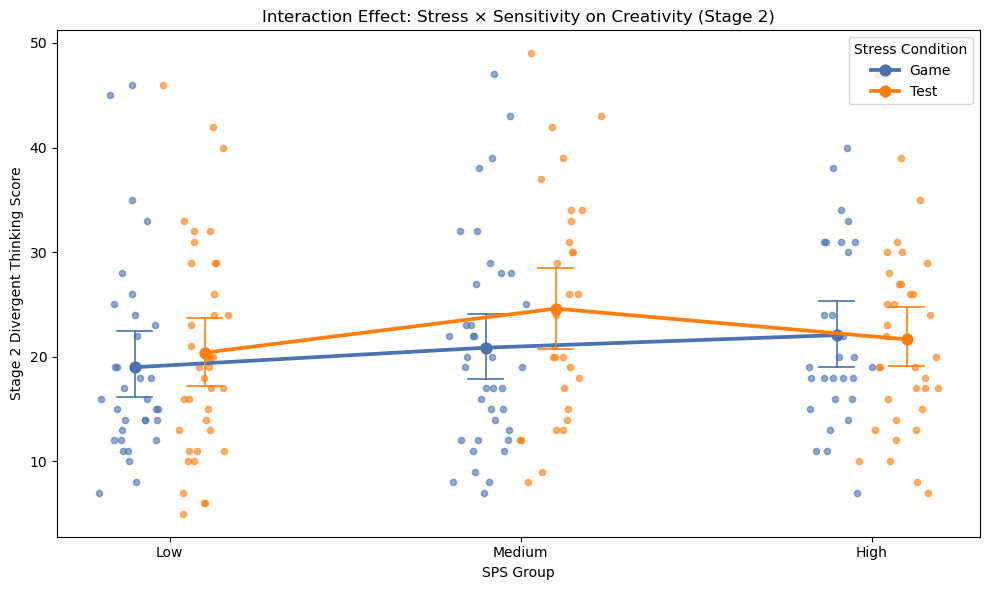

In [17]:
# ---- Step 0: Drop rows with NaN ----
df_plot = df.dropna(subset=['SPS', 'Stage2', 'Group']).copy()

# ---- Step 1: Map Group to string labels ----
df_plot['Group_label'] = df_plot['Group'].map({0: 'Game', 1: 'Test'})

# ---- Step 2: Bin SPS into Low/Medium/High ----
df_plot['SPS_group'] = pd.qcut(df_plot['SPS'], q=3, labels=['Low', 'Medium', 'High'])

# ---- Step 3: Define colors explicitly ----
palette = {'Game': '#4C72B0', 'Test': '#FF7F0E'}

plt.figure(figsize=(10, 6))

# ---- Step 4: Pointplot (lines with error bars) ----
sns.pointplot(
    data=df_plot,
    x='SPS_group',
    y='Stage2',
    hue='Group_label',
    order=['Low', 'Medium', 'High'],
    dodge=0.2,
    capsize=0.1,
    palette=palette,
    err_kws={'linewidth': 1.2}
)

# ---- Step 5: Overlay raw data as scatter ----
for i, sps_level in enumerate(['Low', 'Medium', 'High']):
    for grp_label in ['Game', 'Test']:
        subset = df_plot[(df_plot['SPS_group'] == sps_level) & (df_plot['Group_label'] == grp_label)]
        x_jitter = np.random.normal(i + (-0.1 if grp_label=='Game' else 0.1), 0.05, size=len(subset))
        plt.scatter(x_jitter, subset['Stage2'], color=palette[grp_label], alpha=0.6, s=20)

# ---- Step 6: Labels ----
plt.title('Interaction Effect: Stress × Sensitivity on Creativity (Stage 2)')
plt.xlabel('SPS Group')
plt.ylabel('Stage 2 Divergent Thinking Score')
plt.legend(title='Stress Condition')
plt.tight_layout()
plt.show()

The plot shows Stage 2 Divergent Thinking scores across different Sensory Processing Sensitivity (SPS) groups (Low / Medium / High) under two stress conditions (Game → Low Stress, Test → High Stress). Blue lines and points represent the Game condition, while orange lines and points represent the Test condition. The height of each line reflects the mean score for that SPS group, with error bars indicating the standard error of the mean (SEM), and the scattered points show the distribution of the raw data. The figure suggests a potential interaction effect between SPS group and stress condition, for example, the Medium SPS group shows slightly **higher** scores under the **high-stress** Test condition compared to the **low-stress** Game condition.

The third file, **"03_Exploratory Analysis and Future Directions"** will showcase the exploration of potential data possibilities and provide creative guidance for future research directions.
